In [10]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt


(train_ds, test_ds), ds_info = tfds.load('cifar10', split=['train', 'test'], as_supervised=True, with_info=True)
BATCH_SIZE = 64

#print(ds_info)

In [11]:
## 1.1 Prep dataset
def preprocessing_cifar10(image, label):
    image = tf.cast(image, tf.float32) / 128 - 1
    label = tf.one_hot(label, depth=10)
    return image, label

train_ds = train_ds.map(preprocessing_cifar10)
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(2)



In [3]:
def try_model(model, ds):
  for x, t in ds.take(5):
    y = model(x)



Text(0.5, 1.0, 'Label: 4')

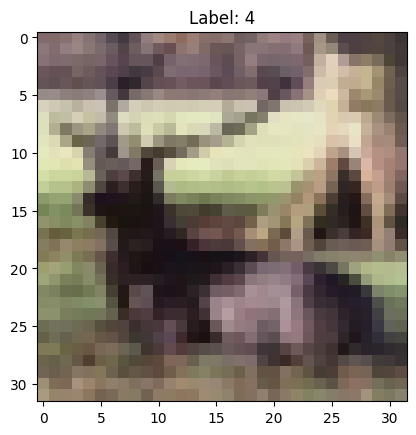

In [8]:
## Visualization
# ectract batch of smaples
sample_batch = next(iter(train_ds))
# unpack batch
sample_image, sample_label = sample_batch

# right now normalized to the range [-1, 1], so rescale it to [0, 1] for visualization purposes
plt.imshow((sample_image[0] + 1) / 2)
plt.title(f"Label: {np.argmax(sample_label[0])}")
#plt.axis("off")

In [22]:
## 1.2 Creation of CNN Model

from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

class MyCNN(tf.keras.Model):
  def __init__(self):
    super(MyCNN, self).__init__()

    self.convlayer1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(32, 32, 3))
    self.convlayer2 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')
    self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

    self.convlayer3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')
    self.convlayer4 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')
    self.global_pool = tf.keras.layers.GlobalAvgPool2D()

    self.out = tf.keras.layers.Dense(10, activation='softmax')


  def call(self, x):
    x = self.convlayer1(x)
    x = self.convlayer2(x)
    x = self.pooling(x)
    x = self.convlayer3(x)
    x = self.convlayer4(x)
    x = self.global_pool(x)
    x = self.out(x)
    return x



# cifar_cnn = MyCNN()
# try_model(cifar_cnn, train_ds)


In [13]:

class DenselyConnectedCNNLayer(tf.keras.layers.Layer):
  def __init__(self, num_filters):
    super(DenselyConnectedCNNLayer, self).__init__()
    self.conv = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=3, padding='same', activation='relu')

  def call(self, x):
    c = self.conv(x)
    x = tf.concat((x,c), axis=-1)
    return x

class DenselyConnectedCNNBlock(tf.keras.layers.Layer):
  def __init__(self, num_filters, layers):
    super(DenselyConnectedCNNBlock, self).__init__()
    self.layers = [DenselyConnectedCNNLayer(num_filters) for _ in range(layers)]

  def call(self, x):
    for layer in self.layers:
      x = layer(x)
    return x


class DenselyConnectedCNN(tf.keras.Model):
  def __init__(self):
    super(DenselyConnectedCNN, self).__init__()

    self.denseblock1 = DenselyConnectedCNNBlock(24,4)
    self.pooling1 = tf.keras.layers.MaxPooling2D()

    self.denseblock2 = DenselyConnectedCNNBlock(24,4)
    self.pooling2 = tf.keras.layers.MaxPooling2D()

    self.denseblock3 = DenselyConnectedCNNBlock(24,4)
    self.globalpooling = tf.keras.layers.GlobalAvgPool2D()
    self.out = tf.keras.layers.Dense(10, activation='softmax')

  def call(self,x):
    x = self.denseblock1(x)
    x = self.pooling1(x)
    x = self.denseblock2(x)
    x = self.pooling2(x)
    x = self.denseblock3(x)
    x = self.globalpooling(x)
    x = self.out(x)
    return x

# dense_model = DenselyConnectedCNN()
# try_model(dense_model, train_ds)


In [29]:
## 1.3 Training


#@tf.function
def train_loop(train_ds, NUM_EPOCHS, LR, loss_function, optimizer):
    model = MyCNN()

    #print(model.summary())

    # define metrics
    train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
    train_losses_metric = tf.keras.metrics.Mean()

    # sore values in lists for later plotting
    train_accuracy_values = []
    train_loss_values = []

    for epoch in range(NUM_EPOCHS):
        print(f"Epoch {epoch}:")

        # reset accuracy metric at the beginning of each epoch
        train_acc_metric.reset_states()

        #
        for x, t in train_ds:
            with tf.GradientTape() as tape:
                pred = model(x)
                l = loss_function(t, pred)

            gradients = tape.gradient(l, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            # update accuracy metric
            train_acc_metric.update_state(t, pred)
            train_losses_metric.update_state(l)

        # calculate accuracy at the end of each epoch
        train_accuracy = train_acc_metric.result().numpy() #numerical value of the accuracy for printing
        train_loss = train_losses_metric.result().numpy()
        print(f"Training Accuracy: {train_accuracy}, Training Loss: {train_loss}")

        # append to value lists for plotting
        train_accuracy_values.append(train_accuracy)
        train_loss_values.append(train_loss)



    # obligatory to return model when wanting to loop test data
    # and onligatory to return value lists for plotting
    return model, train_accuracy_values, train_loss_values


In [30]:
def test_loop(test_ds, trained_model, loss_function):

  test_acc_metric = tf.keras.metrics.CategoricalAccuracy()
  test_losses_metric = tf.keras.metrics.Mean()

  # lists for plotting
  test_acc_values = []
  test_loss_values = []

  for x, t in train_ds:
    pred = trained_model(x)
    loss = loss_function(t, pred)

    test_acc_metric.update_state(t, pred)
    test_losses_metric.update_state(loss)

  test_accuracy = test_acc_metric.result().numpy() #numerical value of the accuracy for printing
  print(f"Testing Accuracy: {test_accuracy}")
  test_loss = test_losses_metric.result().numpy()
  print(f"Testing Loss: {test_loss}")


  test_acc_values.append(test_accuracy)
  test_loss_values.append(test_loss)

  return test_acc_values, test_loss_values




In [26]:
#1: Basic
NUM_EPOCHS = 3
LR = 0.001
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)


# call train loop
trained_model, train_accuracy_values, train_loss_values = train_loop(train_ds, NUM_EPOCHS, LR, loss_function, optimizer)

Epoch 0:
Training Accuracy: 0.4443199932575226, Training Loss: 1.5108553171157837
Epoch 1:
Training Accuracy: 0.6237000226974487, Training Loss: 1.2826778888702393
Epoch 2:
Training Accuracy: 0.6877599954605103, Training Loss: 1.1497795581817627


In [27]:
# call test loop
test_acc_values, test_loss_values = test_loop(test_ds, trained_model, loss_function)

Testing Accuracy: 0.7260400056838989
Testing Loss: 0.7782222032546997


In [ ]:
# plotting 1.0: with subplots per accuaracy/loss value
# train
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_accuracy_values, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_values, label='Training Loss', color='orange')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# test
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.bar(['Testing'], [test_acc_values], color='blue', label='Testing Accuracy')
plt.title('Testing Accuracy')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(['Testing'], [test_loss_values], color='red', label='Testing Loss')
plt.title('Testing Loss')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

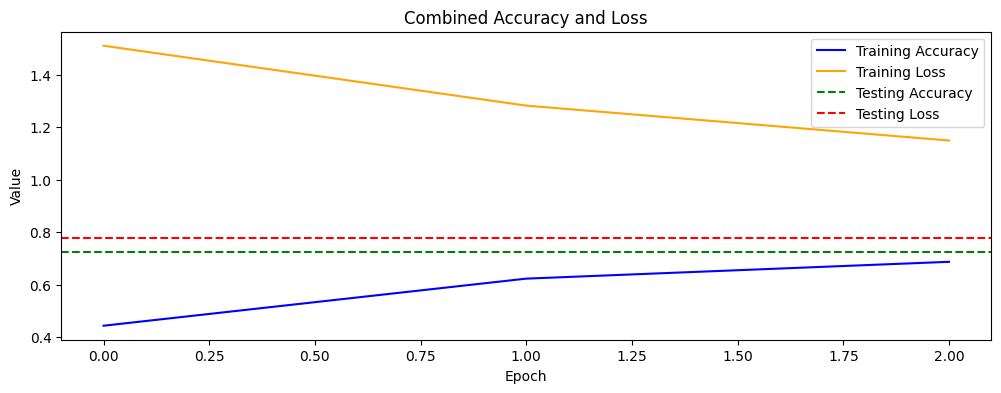

In [31]:
# Plotting 2.0: combined accuracy and loss curves + combined train and test
plt.figure(figsize=(12, 4))

plt.plot(train_accuracy_values, label='Training Accuracy', color='blue')
plt.plot(train_loss_values, label='Training Loss', color='orange')
plt.axhline(y=test_acc_values, color='green', linestyle='--', label='Testing Accuracy')
plt.axhline(y=test_loss_values, color='red', linestyle='--', label='Testing Loss')

plt.title('Combined Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()

plt.show()

In [17]:
#2: with DenselyConnectedCNN
NUM_EPOCHS = 10
LR = 0.001
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)


# call train loop
trained_dense_model = train_loop(train_ds, NUM_EPOCHS, LR, loss_function, optimizer)

Epoch 0:
Training Accuracy: 0.4517799913883209
Epoch 1:
Training Accuracy: 0.6331800222396851
Epoch 2:
Training Accuracy: 0.7019199728965759
Epoch 3:
Training Accuracy: 0.7437199950218201
Epoch 4:
Training Accuracy: 0.7778599858283997
Epoch 5:
Training Accuracy: 0.8040800094604492
Epoch 6:
Training Accuracy: 0.8244199752807617
Epoch 7:
Training Accuracy: 0.8445799946784973
Epoch 8:
Training Accuracy: 0.8586000204086304
Epoch 9:
Training Accuracy: 0.8741999864578247


In [ ]:
#2 call test loop -> Dense
tested_model = test_loop(test_ds, trained_dense_model, loss_function)


In [ ]:
#3: with AdaGrad optimizer
NUM_EPOCHS = 2
LR = 0.001
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.experimental.Adagrad(LR)



# call train loop
trained_adagrad_model = train_loop(train_ds, NUM_EPOCHS, LR, loss_function, optimizer)

In [ ]:
#3 call test loop -> AdaGrad
tested_model = test_loop(test_ds, trained_adagrad_model, loss_function)


In [ ]:
#4: large LR
NUM_EPOCHS = 2
LR = 0.2
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)


# call train loop
trained_lr_large_model = train_loop(train_ds, NUM_EPOCHS, LR, loss_function, optimizer)

In [ ]:
#4 call test loop -> lr
tested_model = test_loop(test_ds, trained_lr_large_model, loss_function)


In [ ]:
#5: small LR
NUM_EPOCHS = 2
LR = 0.000001
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)


# call train loop
trained_lr_small_model = train_loop(train_ds, NUM_EPOCHS, LR, loss_function, optimizer)

In [ ]:
#5 call test loop -> lr
tested_model = test_loop(test_ds, trained_lr_small_model, loss_function)
